In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psql
import matplotlib.pyplot as plt

In [8]:
plt.style.use('seaborn-colorblind')
conn = psql.connect(dbname='datawarehouse',
                       host='localhost', user='gabriel', password='gyfu')

In [3]:
cur = conn.cursor()

cur.execute('select count(f.*), d.month, d.year from fires f left join date d on f.dateid = d.id group by d.month, d.year order by year asc;')

monthlyData = cur.fetchall()
cur.close()

count = []
date = []
for fires in monthlyData:
    count.append(fires[0])
    date.append((fires[1], fires[2]))

firesMonthDB = pd.DataFrame(data={'count': count, 'date': date})

firesMonthDB


,count,date
0,469,"(1, 2008)"
1,356,"(2, 2008)"
2,1234,"(3, 2008)"
3,4832,"(4, 2008)"
4,2283,"(5, 2008)"
...,...,...
109,1246,"(2, 2017)"
110,2619,"(3, 2017)"
111,7099,"(4, 2017)"
112,5277,"(5, 2017)"


<AxesSubplot:xlabel='date'>

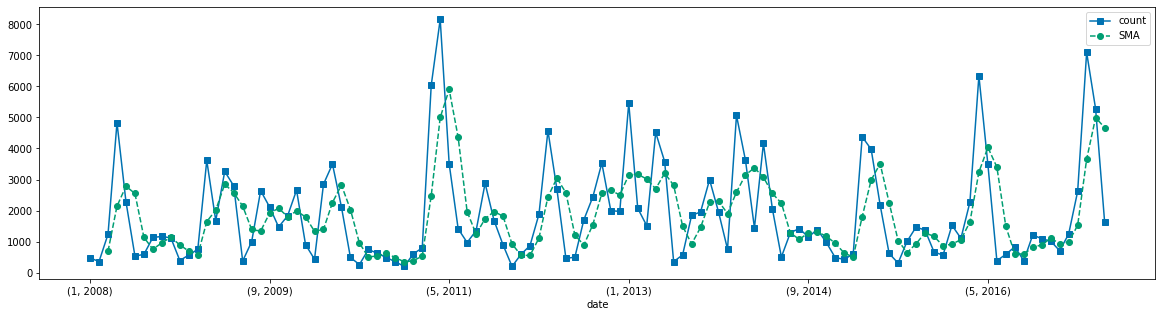

In [19]:
window = 3
firesMonth = firesMonthDB.copy()
for i in range(window - 1, firesMonth.shape[0]):
    firesMonth.loc[firesMonth.index[i], 'SMA'] = 0
    for j in range(0, window):
        firesMonth.iloc[i, firesMonth.columns.get_loc('SMA')] += firesMonth.iloc[i - j, firesMonth.columns.get_loc('count')]
firesMonth['SMA'] = firesMonth['SMA'] / window

firesMonth.plot(x='date', y=['count', 'SMA'],style=['s-', 'o--'], figsize=(20,5))


<AxesSubplot:xlabel='date'>

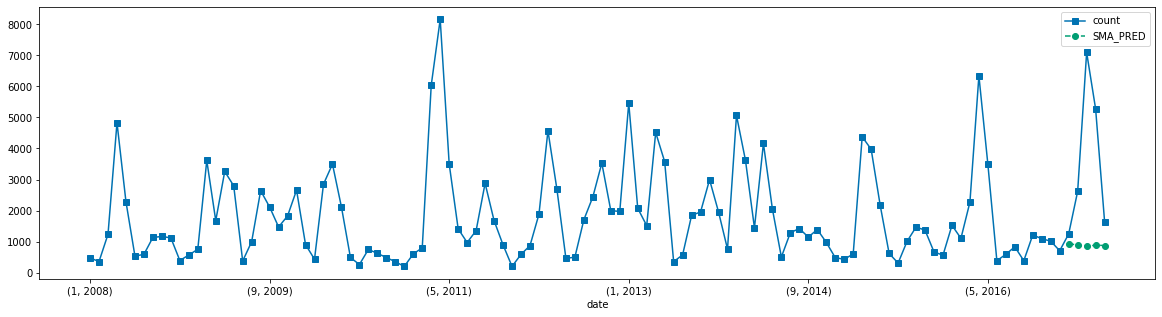

In [18]:
periodsToPredict = 5
window = 3
firesMonthPred = firesMonthDB.copy()
firesMonthPred['SMA_PRED'] = firesMonthPred['count']
for i in range(firesMonthPred.shape[0] - periodsToPredict, firesMonthPred.shape[0]):
    firesMonthPred.iloc[i, firesMonthPred.columns.get_loc('SMA_PRED')] = 0
    for j in range(0, window):
        firesMonthPred.iloc[i, firesMonthPred.columns.get_loc('SMA_PRED')] += firesMonthPred.iloc[i-j-1, firesMonthPred.columns.get_loc('SMA_PRED')]
    firesMonthPred.iloc[i, firesMonthPred.columns.get_loc('SMA_PRED')] /= window

firesMonthPred.iloc[:(firesMonthPred.shape[0] - periodsToPredict), firesMonthPred.columns.get_loc('SMA_PRED')] = float('NaN')
firesMonthPred.plot(x='date', y=['count', 'SMA_PRED'],style=['s-', 'o--'], figsize=(20,5))


<AxesSubplot:xlabel='date'>

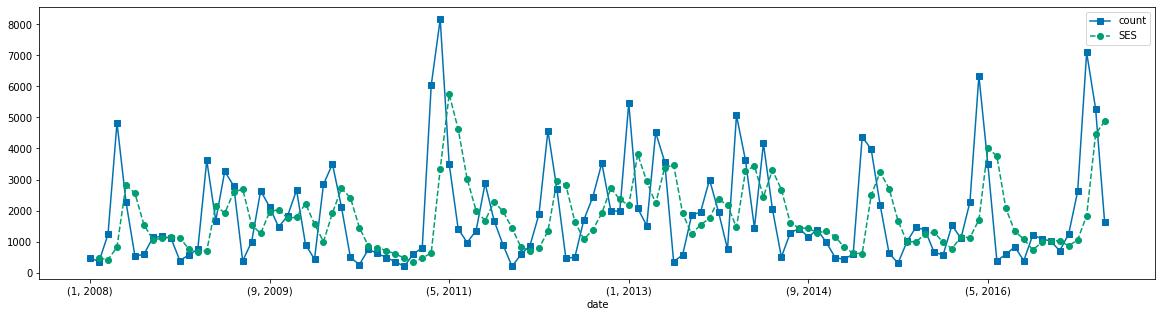

In [21]:
alpha = 0.5
firesMonthSES = firesMonthDB.copy()
firesMonthSES['SES'] = 0
firesMonthSES.iloc[0, firesMonthSES.columns.get_loc('SES')] = float('NaN')
firesMonthSES.iloc[1, firesMonthSES.columns.get_loc('SES')] = firesMonthSES.iloc[0, firesMonthSES.columns.get_loc('count')]
for i in range(2, firesMonthSES.shape[0]):
    firesMonthSES.iloc[i, firesMonthSES.columns.get_loc('SES')] = alpha * firesMonthSES.iloc[i-1, firesMonthSES.columns.get_loc('count')]
    firesMonthSES.iloc[i, firesMonthSES.columns.get_loc('SES')] += (1 - alpha) * firesMonthSES.iloc[i-1, firesMonthSES.columns.get_loc('SES')]
firesMonthSES.plot(x='date', y=['count', 'SES'],style=['s-', 'o--'], figsize=(20,5))

<AxesSubplot:xlabel='date'>

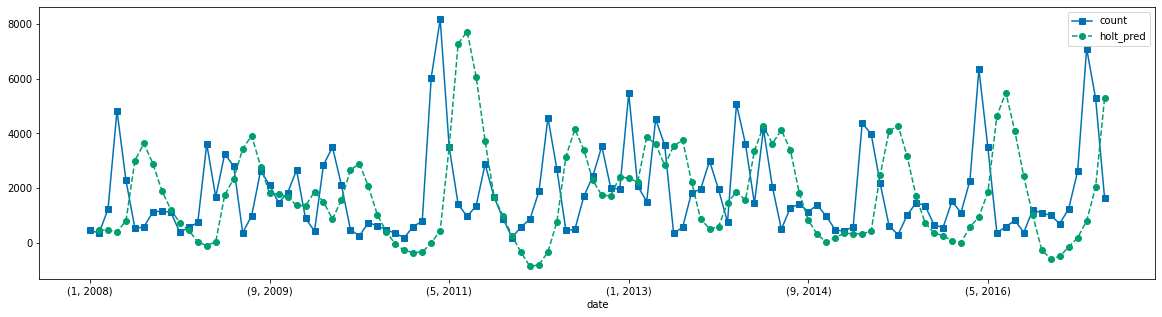

In [23]:
alpha = 0.5
beta = 0.5
firesMonthHolt = firesMonthDB.copy()
firesMonthHolt['holt'] = 0
firesMonthHolt['trend'] = 0
firesMonthHolt['holt_pred'] = 0

firesMonthHolt.iloc[0, firesMonthHolt.columns.get_loc('holt')] = float('NaN')
firesMonthHolt.iloc[0, firesMonthHolt.columns.get_loc('holt_pred')] = float('NaN')
firesMonthHolt.iloc[1, firesMonthHolt.columns.get_loc('holt')] = firesMonthHolt.iloc[0, firesMonthHolt.columns.get_loc('count')]
firesMonthHolt.iloc[1, firesMonthHolt.columns.get_loc('holt_pred')] = firesMonthHolt.iloc[0, firesMonthHolt.columns.get_loc('count')]

for i in range(2, firesMonthHolt.shape[0]):
    firesMonthHolt.iloc[i, firesMonthHolt.columns.get_loc('holt_pred')] = firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('holt')] + firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('trend')]
    st = alpha * firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('count')]
    st += (1 - alpha) * (firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('holt')] + firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('trend')])
    firesMonthHolt.iloc[i, firesMonthHolt.columns.get_loc('holt')] = st
    mt = beta * (st - firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('holt')])
    mt += (1 - beta) * (firesMonthHolt.iloc[i-1, firesMonthHolt.columns.get_loc('trend')])
    firesMonthHolt.iloc[i, firesMonthHolt.columns.get_loc('trend')] = mt
firesMonthHolt.plot(x='date', y=['count', 'holt_pred'],style=['s-', 'o--'], figsize=(20,5))

In [24]:
conn.close()